In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import os.path

import plot
import calculate

# I moved this part to 1. Data Preprocessing

In [2]:
authorPublicationData = pd.read_csv('data/author_publications_2017_asiansAsNone.txt')

authorPublicationData.head()

,author,year,pub_id
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
4,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1


### 1.7 million authors and 3 million publications over 47 years (1970 to 2016) are available from the data

In [3]:
#Unique values
print('Authors# - ',authorPublicationData['author'].nunique())
print('Year# - ',authorPublicationData['year'].nunique())
print('Publications# - ',authorPublicationData['pub_id'].nunique())

#old data value
#('Authors# - ', 1708185)
#('Year# - ', 47)
#('Publications# - ', 3085544)

# new data value
#Authors# -  1704919
#Year# -  83
#Publications# -  3078230

# # how many unique publications per author? In how many unique years was an author active
# # this takes some time, but we can save result to file
# file = "./data/author_unique_pubs_and_years2.csv"
# from pathlib import Path

# if not os.path.exists(file):
#     print("File does not exists - creating !!!")
#     table = authorPublicationsData.groupby("author").aggregate({'year': pd.Series.nunique, 'pub_id': pd.Series.nunique})
#     table.head()
#     table.to_csv(file, header=True, encoding="utf-8")
# else:
#     table = pd.read_csv(file, encoding="utf-8", header=0)

# table.head(20)

Authors# -  1704919
Year# -  83
Publications# -  3078230


In [4]:
#Publication ID details are irrelevant for analysis - Keep the count information for each author

authorPublicationData = authorPublicationData.groupby(['year','author']).count().reset_index()
authorPublicationData.rename(columns={'pub_id':'num_pub'}, inplace=True)

In [5]:
#get the year list - as it helps to enumerate and find gini co-efficient for each year (irrespective of the dataset)
years = np.sort(authorPublicationData['year'].unique())
print(years)

[1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]


### Compute Start, End year, Publication count and Career length for each author

In [6]:
#Group by author and find their start and end of their career by looking at their publish details
# and also count the no. of publications that he/she has
groupByAuthor = authorPublicationData.groupby(['author'])
# find the minimum and maximum year of publications and its count for each author
groupByAuthorMinYearData = groupByAuthor['year'].min()
groupByAuthorMaxYearData = groupByAuthor['year'].max()
groupByAuthorCountPublicationsData = groupByAuthor['num_pub'].sum()

In [7]:
# merge all the information into one and save it to a file
authorScientificYearStart = groupByAuthorMinYearData.reset_index()
authorScientificYearStart.rename(inplace=True, columns={'author':'author','year':'start_year'})
authorScientificYearEnd = groupByAuthorMaxYearData.reset_index()
authorScientificYearEnd.rename(inplace=True, columns={'author':'author','year':'end_year'})
authorPublishCount = groupByAuthorCountPublicationsData.reset_index()
authorPublishCount.rename(inplace=True, columns={'author':'author','num_pub':'total_num_pub'})

authorScientificYearStartEnd = authorScientificYearStart.merge(authorScientificYearEnd,on='author')
authorScientificYearStartEnd_publish_count = authorScientificYearStartEnd.merge(authorPublishCount,on='author')

print('authorScientificYearStartEnd_publish_count before filtering - ',authorScientificYearStartEnd_publish_count.shape[0])
authorScientificYearStartEnd_publish_count = authorScientificYearStartEnd_publish_count[authorScientificYearStartEnd_publish_count["start_year"] >= 1970]
print('authorScientificYearStartEnd_publish_count after filtering - ',authorScientificYearStartEnd_publish_count.shape[0])

print("authorScientificYearStartEnd_publish_count with duplicates: %s", authorScientificYearStartEnd_publish_count.shape[0])
authorScientificYearStartEnd_publish_count = authorScientificYearStartEnd_publish_count.drop_duplicates()
print("authorScientificYearStartEnd_publish_count with no duplicates: %s", authorScientificYearStartEnd_publish_count.shape[0])

print("authorScientificYearStartEnd_publish_count with null values: %s", authorScientificYearStartEnd_publish_count.shape[0])
authorScientificYearStartEnd_publish_count = authorScientificYearStartEnd_publish_count.dropna(how='any')
print("authorScientificYearStartEnd_publish_count without null values: %s", authorScientificYearStartEnd_publish_count.shape[0])

print(authorScientificYearStartEnd_publish_count.head())

authorScientificYearStartEnd_publish_count before filtering -  1704919
authorScientificYearStartEnd_publish_count after filtering -  1699352
authorScientificYearStartEnd_publish_count with duplicates: %s 1699352
authorScientificYearStartEnd_publish_count with no duplicates: %s 1699352
authorScientificYearStartEnd_publish_count with null values: %s 1699352
authorScientificYearStartEnd_publish_count without null values: %s 1699352
                  author  start_year  end_year  total_num_pub
0       'maseka lesaoana        2001      2015              2
1  (max) zong-ming cheng        2009      2011              2
2       (zhou) bryan bai        2011      2012              2
3        a aart blokhuis        1992      2005              2
4             a ahrabian        2017      2017              1


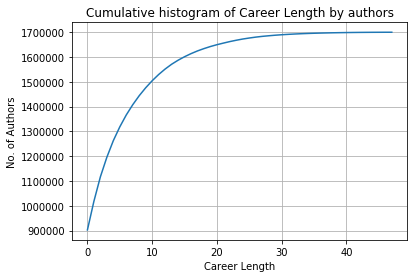

In [8]:
authorScientificYearStartEnd_publish_count["career_length"] = authorScientificYearStartEnd_publish_count['end_year'] - \
                                                              authorScientificYearStartEnd_publish_count['start_year']   
#authorScientificYearStartEnd_publish_count["career_length"].plot.hist(bins=40)
careerLengthDist = authorScientificYearStartEnd_publish_count.groupby(["career_length"])['author'].count()
temp = careerLengthDist.cumsum()  
ax = temp.plot(grid=True, title='Cumulative histogram of Career Length by authors')
ax.set_xlabel('Career Length')
ax.set_ylabel('No. of Authors')

plt.show()

### Save the data for futher usage

In [23]:
CAREER_LENGTH_LIST = [0,3,5,10,15]

for CAREER_LENGTH in CAREER_LENGTH_LIST:
    credible_authors = authorScientificYearStartEnd_publish_count[authorScientificYearStartEnd_publish_count['career_length'] >= CAREER_LENGTH]
    credible_authors.to_csv('data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv',
                        index=False, encoding='utf-8')
    

# fig = plt.figure(figsize=(20,10))
# ax1 = fig.add_subplot(1,1,1)
# authorPublicationData.boxplot(ax=ax1,column='num_pub',by='year', showfliers=False, return_type='axes')
# plt.show()

# Todo: sort out

#### There are about 1.7 milliion authors.  More than 900K (nearly half of all authors) have ended their career on the same year they started. Nearly 1.5 million authors have career length less than 10 years. 

#### In order to prove cumulative advantage exists - analysis should be done among scientists who perform to some extent atleast, which is measured by their career length. The inclusion of many non-performing scientists will impact the GINI coefficient anyways which is used as a measure of inequality in performances

#### An appropriate career length should be chosen which

##### 1) removes many non-performing scientists 
##### 2) allows enough size in each cohort group 
##### 3) gives considerable years to compare their performance

KeyError: 'the label [51] is not in the [index]'

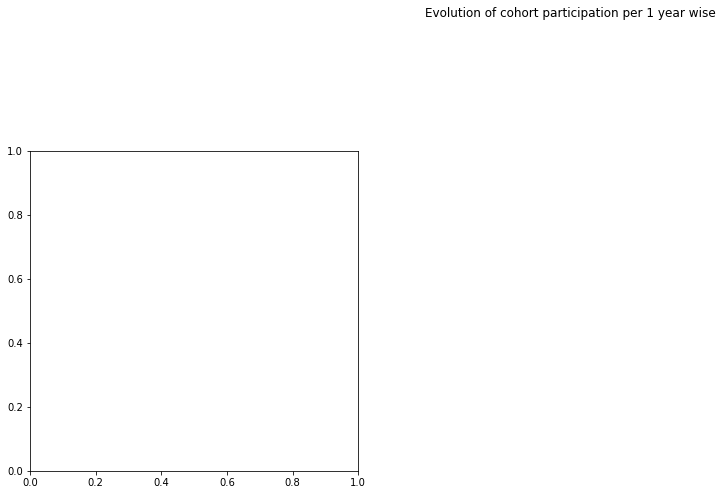

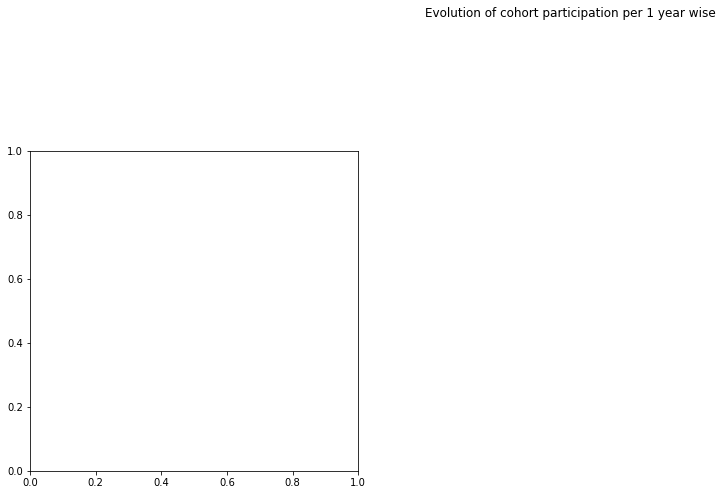

In [9]:
#Try with different career length and see (what fraction of/how many of researchers) in each cohort is available over their career span
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
#CAREER_LENGTH_LIST = [0]

plot.plot_cohort_participation_year_wise_for(authorScientificYearStartEnd_publish_count, authorPublicationData,CAREER_LENGTH_LIST)

Notes or Analysis:
* Our baseline for this analysis - it is mandatory to have atleast 100 authors in each cohort and 10 cohorts atleast should be analysed for atleast 10 years
* Good news is that - in all the above constraints we have 100 authors per each cohort. (20% of cohort size is maintained)

20-30 cohorts are good enough, considering that, career length -15 and 20 is looking promising

In [ ]:
#just for debugging
from importlib import reload
reload(plot)
reload(calculate)

### Group the authors by contribution in 2 years

In [ ]:
groupByYearData = authorPublicationData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(5))
# GROUPING BY 2 years
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_pub')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(5))

In [ ]:
#Try with different career length and see (what fraction of/how many of researchers) in each cohort is available over their career span
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
#CAREER_LENGTH_LIST = [0]
plot.plot_cohort_participation_year_wise_for(authorScientificYearStartEnd_publish_count, groupByYearData,CAREER_LENGTH_LIST)

### Group the authors by contribution in 3 years

In [ ]:
groupByYearData = authorPublicationData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(5))
# GROUPING BY 2 years
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_pub')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(5))

In [ ]:
#Try with different career length and see (what fraction of/how many of researchers) in each cohort is available over their career span
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
#CAREER_LENGTH_LIST = [0]
plot.plot_cohort_participation_year_wise_for(authorScientificYearStartEnd_publish_count, groupByYearData,CAREER_LENGTH_LIST)

### END - the rest of the code can be avoided

### Filter Cohorts: remove authors who have less than N years of career 


In [ ]:
# Make a list of career length 
step = 3
count = (max(years) - min(years)) / step
count = int(count)
career_length_list = range(count+1) 
career_length_list = [num*step for num in career_length_list]
print(career_length_list)

In [ ]:
career_length_cohort = pd.DataFrame(index=years)
per_career_length_cohort = pd.DataFrame(index=years)

career_age_0 = authorScientificYearStartEnd_publish_count.groupby(['start_year'])['author'].count()
for career_length in range(0,(max(years) - min(years))):
    temp = authorScientificYearStartEnd_publish_count[authorScientificYearStartEnd_publish_count['career_length'] >= career_length]
    career_length_cohort[str(career_length)] = temp.groupby(['start_year'])['author'].count()
    per_career_length_cohort[str(career_length)] = career_length_cohort[str(career_length)] / career_age_0
    
career_length_cohort.replace(to_replace=np.NaN, value=0, inplace=True)
career_length_cohort.head()

per_career_length_cohort.replace(to_replace=np.NaN, value=0, inplace=True)
per_career_length_cohort.head()

In [ ]:
interested_career_lengths = [str(num) for num in range(0,10)]
per_career_length_cohort[interested_career_lengths].plot(kind='area', stacked=False)

In [ ]:
interested_career_lengths = [str(num) for num in range(0,20,5)]
per_career_length_cohort[interested_career_lengths].plot(kind='area', stacked=False)

In [ ]:
per_career_length_cohort[['0','5','10','15','20','40']].plot(kind='area', stacked=False)

In [ ]:
new_df['0'].values

In [ ]:
percentage_df = new_df / new_df['0'].values
percentage_df.head()

In [ ]:
career_atleast_5_years = cohortGroup[cohortGroup['career_length'] > 5]
career_atleast_5_years.head()

In [ ]:
N = 15

authorScientificYearStartEnd_publish_count["career_length"] = authorScientificYearStartEnd_publish_count['end_year'] - authorScientificYearStartEnd_publish_count['start_year']   
#print(authorScientificYearStartEnd_publish_count.head())

credible_authors = authorScientificYearStartEnd_publish_count[authorScientificYearStartEnd_publish_count.career_length >= N ]
#print(credible_authors.head())

credible_cohort = credible_authors.groupby("start_year").count()
credible_cohort.rename(columns = {'author':'num_author_filtered'}, inplace = True)
#print(credible_cohort.head())

# how many people remain in each cohort after filtering
print(credible_cohort["num_author_filtered"].describe())

#looks like we only observe 10 or more career years for people who started later --> DBPL coverage became better in later years
print(credible_cohort.reset_index()["start_year"].unique())

# visualize changes after filtering!

num_newbies.rename(columns = {'author':'num_author'}, inplace = True)
cohort_size = pd.DataFrame(num_newbies["num_author"]).join(credible_cohort["num_author_filtered"])
#print(cohort_size)


fig, ax = plt.subplots()
width = 0.3       # the width of the bars
Y = len(cohort_size.reset_index()["start_year"])
ind = np.arange(Y)

rects1 = ax.bar(ind, cohort_size["num_author"], width, color='b')
rects2 = ax.bar(ind+ width, cohort_size["num_author_filtered"], width, color='r')
ax.set_ylabel('num scientists')
ax.set_title('Cohort Size')
ax.set_xticks(ind + width / 2)

ax.set_xticklabels(cohort_size.reset_index()["start_year"], rotation=90)

ax.legend((rects1[0], rects2[0]), ('all', 'more than '+str(N)+'years'))


In [ ]:
print(ind)

In [ ]:
credible_authors.to_csv(folder+'/authors-scientific-atleast-'+str(N)+'-year.csv',
                        index=False, encoding='utf-8')

In [ ]:
print(authorPublicationsData.head())

credibleAuthorPublicationsData = authorPublicationsData[authorPublicationsData['author'].isin(credible_authors['author'])]
credibleAuthorPublicationsData.reset_index(inplace=True)

#Crosschecking whether the filtering worked or not
print('Authors# - ',credibleAuthorPublicationsData['author'].nunique())
print('Year# - ',credibleAuthorPublicationsData['year'].nunique())
print('Publications# - ',credibleAuthorPublicationsData['pub_id'].nunique())

In [ ]:
#todo: remove this part to avoid redundancy and copied code

### For scientists-10-years-10-papers
#### We examine when authors start their publications and how does their distribution looks like
#### At the same time, when does their scientific career ends and how does the distribution looks like

In [ ]:
#Group by author
groupByAuthor = credibleAuthorPublicationsData.groupby(['author'])
# find the minimum and maximum year of publications and its count for each author
groupByAuthorMinYearData = groupByAuthor['year'].min()
groupByAuthorMaxYearData = groupByAuthor['year'].max()
groupByAuthorCountPublicationsData = groupByAuthor['pub_id'].count()

### More no. of new scientfic researchers are involved as the year progresses
#### At year 2005 - fewer new scientists have published ( as of now ignoring it - could be a problem in code)
#### No. of cohort groups is 36
#### Minimum cohort size is 433 and maximum is 8465
#### 75% of 36 groups are over 736 in group size

In [ ]:
scientificYearStartHistogram = groupByAuthorMinYearData.value_counts(sort=False)
ax = scientificYearStartHistogram.sort_index().plot(kind='bar', title='Start of Scientific career histogram')
ax.set_xlabel("Year")
ax.set_ylabel("No. of authors who published first time")

plt.show()

scientificYearStartHistogram.describe()

In [ ]:
#Manually checked to ensure they are right
scientificYearStartHistogram.sort_index()

In [ ]:
scientificYearStartHistogram = groupByAuthorMinYearData.value_counts(sort=False)
ax = scientificYearStartHistogram[scientificYearStartHistogram.index < 2000].sort_index().plot(kind='bar', title='Start of Scientific career histogram')
ax.set_xlabel("Year")
ax.set_ylabel("No. of authors who published first time")

plt.show()

scientificYearStartHistogram[scientificYearStartHistogram.index < 2000].describe()

### Culmination of research increases as  year progresses - Correlates with the increase of Start of Scientific career
#### At year 2016, there is a dip - need to analyse it - we shall ignore for this moment

In [ ]:
scientificYearEndHistogram = groupByAuthorMaxYearData.value_counts(sort=False)
ax = scientificYearEndHistogram.sort_index().plot(kind='bar', 
                                                  title='End of Scientific career histogram')
ax.set_xlabel("Year")
ax.set_ylabel("No. of authors who published last time")
#ax.set_ylim([0,3000])
plt.show()

scientificYearEndHistogram.describe()

In [ ]:
scientificYearEndHistogram.sort_index()

#### Some other analysis that could be done  are
1) We find the best/better cohort group(s) that can be compared. As of now, if we consider atleast 15 years of research can be used for comparison then we have 32 cohort groups (1970 to 2001)
Best cohort group - similar characteristics (there might be many reasons for one to end his/her scientific career)
Consider people who start and at the same time end their career as well ???
Also Consider their growth (their peak time and the trend) ???

2) Increase the cohort group size - Can group the authors by years

3) Drop out rates are high - this is why we insist 10/20 year 10/20 paper constraint

### For scientists-20-years-20-papers
#### We examine when authors start their publications and how does their distribution looks like
#### At the same time, when does their scientific career ends and how does the distribution looks like

In [ ]:
credibleAuthorPublicationsData = authorPublicationsData[authorPublicationsData['author'].isin(credible_authors_20['author'])]
credibleAuthorPublicationsData.reset_index(inplace=True)

#Crosschecking whether the filtering worked or not
print('Authors# - ',credibleAuthorPublicationsData['author'].nunique())
print('Year# - ',credibleAuthorPublicationsData['year'].nunique())
print('Publications# - ',credibleAuthorPublicationsData['pub_id'].nunique())

In [ ]:
#Group by author
groupByAuthor = credibleAuthorPublicationsData.groupby(['author'])
# find the minimum and maximum year of publications and its count for each author
groupByAuthorMinYearData = groupByAuthor['year'].min()
groupByAuthorMaxYearData = groupByAuthor['year'].max()
groupByAuthorCountPublicationsData = groupByAuthor['pub_id'].count()

In [ ]:
scientificYearStartHistogram = groupByAuthorMinYearData.value_counts(sort=False)
ax = scientificYearStartHistogram.sort_index().plot(kind='bar', title='Start of Scientific career histogram')
ax.set_xlabel("Year")
ax.set_ylabel("No. of authors who published first time")
plt.show()

scientificYearStartHistogram.describe()

In [ ]:
scientificYearEndHistogram = groupByAuthorMaxYearData.value_counts(sort=False)
ax = scientificYearEndHistogram.sort_index().plot(kind='bar', title='End of Scientific career histogram')
ax.set_xlabel("Year")
ax.set_ylabel("No. of authors who published last time")
plt.show()

scientificYearEndHistogram.describe()

In [ ]:
end_time = timeit.default_timer()
print('End Time (in sec) - ',end_time)
print('Time taken (in sec) - ',end_time-start_time)

### Cohort Size group (whether individual years are good enough or clubs of few years are required)

* A cohort is a set of researchers that started their career in the same year. We use the first publication of a research as proxy for his/her career start. Since we want to follow researchers over time, we only include researchers that were active over at least 10 years (i.e., they published at least 2 papers, their first one and another one 10 years later)
* What is the size of each cohort?
* Record for those people how many papers they publish in each year, how many citations they have received, their h-index


#### First and foremost - let us look at the performance of researchers
#### We need to remove the dropouts based on following condition
##### researchers whose career span is less than 10 years 
##### and has published less than 10 papers (necessary ? - as of now keeping it)